### Conclusion
* Right angle + power > just power or just angle
* hit the sweet spot but keep ld not too high
* top players have their ways to survive in the league
* Power/angle/eye/speed


### Finding
* Pay attention to /players/p/pierza.01.shtml only player id with "."
* 681 unduplicated batters >= 162 PA between 2015 and 2019
* 1925 data points >= 162 PA between 2015 and 2019
* Some % data are string data type = >need to convert if be used
* Features: 
  * Keep: barrel_batted_rate, barrel_hard, barrel_sweet, sprint_speed
  * Remove?: FB%, Age
  * Select between: 
    * swing_percent, z_s_contact_percent, oz_swing_miss_percent
    * z_swing_percent, oz_swing_percent, iz_contact_percent, oz_swing_miss_percent

### Completed
* Web-scraping on baseball reference by year to get the list of 2015-2019 batters
* Web-scraping on baseball reference by players to get advance stats
* Data frame
* Data into sql database
* Merge Baseball Reference data with Baseball Savant data
* EDA
* Decide baseline features
* split the data
* baseline model
* feature selection

### To do
* model selection
* cross validation

In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import scipy.stats as stats
import itertools

In [2]:
engine = create_engine('sqlite:///batters.db')

In [3]:
inspect(engine).get_table_names()

['br', 'pitches', 'players', 'statcast']

In [4]:
pd.read_sql('SELECT * FROM br;', engine).columns

Index(['index', 'Html_id', 'Name', 'Year', 'Age', 'Tm', 'Lg', 'G', 'PA', 'AB',
       'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB',
       'Pos_Summary', 'Awards', 'rOBA', 'Rbat+', 'BAbip', 'ISO', 'HR%', 'SO%',
       'BB%', 'EV', 'HardH%', 'LD%', 'GB%', 'FB%', 'GB/FB', 'Pull%', 'Cent%',
       'Oppo%', 'WPA', 'cWPA', 'RE24', 'RS%', 'SB%', 'XBT%', 'XBH%', 'X/H%',
       'SO/W', 'AB/SO', 'AB/HR', 'AB/RBI', 'GO/AO', 'IP%', 'HR/FB', 'IF/FB',
       'PA_cum', 'PA_cum_0', 'MLB_year', 'PA_0', 'PA_3y', 'PA_3y_0', 'PA_2y',
       'PA_2y_0', 'OPS+_3y', 'OPS+_3y_0', 'OPS+_2y', 'OPS+_2y_0', 'OPS+_last',
       'OPS+_next'],
      dtype='object')

In [5]:
pd.read_sql('SELECT * FROM statcast;', engine).columns

Index(['index', 'last_name', 'first_name', 'player_id', 'year', 'player_age',
       'b_total_pa', 'b_total_hits', 'b_home_run', 'b_total_pitches',
       'exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent',
       'barrels', 'barrel_batted_rate', 'hard_hit_percent', 'z_swing_percent',
       'z_swing_miss_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'out_zone_swing_miss', 'out_zone_swing',
       'out_zone_percent', 'meatball_swing_percent', 'meatball_percent',
       'iz_contact_percent', 'in_zone_percent', 'whiff_percent',
       'swing_percent', 'f_strike_percent', 'popups_percent', 'hp_to_1b',
       'sprint_speed', 'Unnamed: 33'],
      dtype='object')

In [4]:
########must run to update############
df = pd.read_sql('''SELECT b.name, s.first_name, s.last_name, b.year, b.mlb_year, b.age,
                           b.[ops+_last], b.[ops+_3y_0], b.[ops+_2y_0],
                           b.pa, b.pa_cum_0, b.pa_0, b.pa_2y_0, b.pa_3y_0, 
                           s.b_total_pitches * 1.0 / b.pa [p/pa], 
                           b.ev, b.[hardh%], s.launch_angle_avg, s.sweet_spot_percent, s.barrel_batted_rate,
                           b.[ld%], b.[gb%], b.[fb%], b.[gb/fb], 
                           b.[pull%], b.[cent%], b.[oppo%], 
                           b.[so/w], b.[go/ao], b.[ip%], b.[hr/fb], b.[if/fb],
                           s.z_swing_percent, s.z_swing_miss_percent, s.iz_contact_percent,
                           s.oz_swing_percent, s.oz_swing_miss_percent, s.oz_contact_percent,
                           s.meatball_swing_percent, s.whiff_percent, s.swing_percent,
                           s.popups_percent, s.sprint_speed, 
                           p.out_zone, p.out_zone_swing, p.out_zone_swing_miss, 
                           p.in_zone, p.in_zone_swing,  p.in_zone_swing_miss,
                           b.slg, b.babip, b.ops,b.[ops+]
                     FROM br b
                     JOIN statcast s
                     ON b.year = s.year
                     AND b.pa = s.b_total_pa
                     AND b.h = s.b_total_hits
                     AND b.hr = s.b_home_run
                     JOIN pitches p
                     ON s.player_id = p.player_id
                     AND s.year=p.year;''', engine)#.dropna(how='any') 
#s.hp_to_1b, 
#Feature Engineering
df['Debut'] = pd.get_dummies(df.PA_3y_0, dummy_na=True).iloc[:, -1]
df['PA_0'] = df['PA_0'].fillna(0)
df['PA_2y_0'] = df['PA_2y_0'].fillna(0)
df['PA_3y_0'] = df['PA_3y_0'].fillna(0)
df['OPS+_last'].fillna(100, inplace=True)
df['OPS+_2y_0'].fillna(100, inplace=True)
df['OPS+_3y_0'].fillna(100, inplace=True)
df['Debut_Age'] = df['Age'] - df['MLB_year']
df['19_LA'] = df['launch_angle_avg'].map(lambda x : abs(x-19))
df['z_s_contact_percent'] = df['z_swing_percent'] * df['iz_contact_percent'] / 100
df['z_tot_miss_percent'] = 100 - df['z_swing_percent'] + df['z_swing_percent']*df['z_swing_miss_percent']/100
df['barrel_hard'] = df['HardH%'] - df['barrel_batted_rate'] 
df['barrel_sweet'] = df['sweet_spot_percent'] - df['barrel_batted_rate']
df['zcontact_ocontact'] = df['iz_contact_percent'] + df['oz_contact_percent']
df['zswing_oswing'] = df['z_swing_percent'] - df['oz_swing_percent']
df['z_contact'] = (df['in_zone_swing'] - df['in_zone_swing_miss'])/df['in_zone'] * 100
df['o_s_miss'] = df['out_zone_swing_miss']/df['out_zone'] * 100
df['o_s_contact'] = (df['out_zone_swing'] -  df['out_zone_swing_miss'])/df['out_zone'] * 100
df['see_o'] = (1 - df['out_zone_swing']/df['out_zone']) *100
df['see_z'] = df['in_zone_swing']/df['out_zone'] *100
df['Age_m'] = df['Age'] - 17
#Major League Baseball has an 18-year-old minimum for U.S. players and 17 for international players. 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1925 non-null   object 
 1   first_name              1925 non-null   object 
 2   last_name               1925 non-null   object 
 3   Year                    1925 non-null   int64  
 4   MLB_year                1925 non-null   int64  
 5   Age                     1925 non-null   int64  
 6   OPS+_last               1925 non-null   float64
 7   OPS+_3y_0               1925 non-null   float64
 8   OPS+_2y_0               1925 non-null   float64
 9   PA                      1925 non-null   int64  
 10  PA_cum_0                1925 non-null   int64  
 11  PA_0                    1925 non-null   float64
 12  PA_2y_0                 1925 non-null   float64
 13  PA_3y_0                 1925 non-null   float64
 14  p/pa                    1925 non-null   

In [506]:
df.describe()

,Year,MLB_year,Age,OPS+_last,OPS+_3y_0,OPS+_2y_0,PA,PA_cum_0,PA_0,PA_2y_0,...,barrel_hard,barrel_sweet,zcontact_ocontact,zswing_oswing,z_contact,o_s_miss,o_s_contact,see_o,see_z,Age_m
count,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,...,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000
mean,2017.021818,5.182857,28.334026,98.634286,97.300693,97.887532,428.038961,2109.433766,370.684156,358.252468,...,32.572623,26.523169,4958.966156,2.448118,55.701969,11.285135,17.098145,71.616719,62.725335,11.334026
std,1.419914,3.870140,3.855108,36.883706,33.002469,33.695819,161.897648,2155.266875,222.436071,211.120128,...,5.957532,4.720128,1042.017173,0.488466,5.152969,3.380997,4.772092,6.036109,7.263270,3.855108
min,2015.000000,0.000000,19.000000,-100.000000,-100.000000,-100.000000,162.000000,0.000000,0.000000,0.000000,...,8.700000,4.800000,1658.800000,1.460000,39.053254,3.046358,3.066038,51.944167,39.320388,2.000000
25%,2016.000000,2.000000,25.000000,84.000000,83.333333,84.500000,280.000000,404.000000,187.000000,182.000000,...,29.000000,23.300000,4243.600000,2.099379,52.017937,8.866995,13.750000,67.730496,57.554945,8.000000
50%,2017.000000,4.000000,28.000000,100.000000,100.000000,100.000000,428.000000,1422.000000,401.000000,386.000000,...,33.000000,26.500000,4941.180000,2.372694,55.592654,11.029412,16.777042,71.875000,62.464183,11.000000
75%,2018.000000,8.000000,31.000000,116.000000,112.666667,113.500000,568.000000,3140.000000,566.000000,535.000000,...,36.500000,29.800000,5673.580000,2.712121,59.215686,13.447653,20.246085,75.941080,67.543860,14.000000
max,2019.000000,21.000000,43.000000,559.000000,559.000000,559.000000,747.000000,11964.000000,745.000000,734.000000,...,52.900000,42.200000,8143.200000,5.637255,78.966790,27.617602,36.594912,89.764869,87.687688,26.000000


Baseline-> all training data  / cross-val(K1 K2 K3 K4 K5) / Test 20%

SELECT FEATURES/FEATURE ENIGERING  -> CROSS-VAL -> k2 MODEL -> TEST
5~10 FEATURES 


In [209]:
df['see_o'].describe()

count    1925.000000
mean       71.616719
std         6.036109
min        51.944167
25%        67.730496
50%        71.875000
75%        75.941080
max        89.764869
Name: see_o, dtype: float64

In [211]:
df['see_z']-df['z_swing_percent']

0      -20.830993
1       -6.803030
2       -4.934540
3       -6.395181
4      -11.031327
          ...    
1920    -1.207937
1921    -1.676602
1922    11.038662
1923    -7.614286
1924    -4.502950
Length: 1925, dtype: float64

## Split data

In [5]:
##########must run##########
#X, y = df.drop('OPS+',axis=1), df['OPS+']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
df_train, df_test = train_test_split(df, test_size=.2, random_state=42)

## Modeling

In [283]:
df_train['Age_m'].describe()

count    1540.000000
mean       11.441558
std         3.927357
min         2.000000
25%         8.000000
50%        11.000000
75%        14.000000
max        26.000000
Name: Age_m, dtype: float64

In [25]:
X_train = df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','swing_percent',
                    'z_s_contact_percent','oz_swing_miss_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     258.5
Date:                Wed, 29 Sep 2021   Prob (F-statistic):          1.24e-299
Time:                        13:00:20   Log-Likelihood:                -6450.8
No. Observations:                1540   AIC:                         1.292e+04
Df Residuals:                    1530   BIC:                         1.297e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -41.5330     12.310     -3.374      0.001     -65.680     -17.386
barrel_batted_rate        6.2634      0.173     36.180      0.000       5.924       6.603
barrel_hard               0.6575      0.081      8.118      0.000       0.499       0.816
barrel_sweet              1.3928      0.110     12.691      0.000       1.178       1.608
FB%                      -0.5222      0.101     -5.165      0.000      -0.721      -0.324
Age_m                    -0.3932      0.121     -3.261      0.001      -0.630      -0.157
swing_percent            -1.5676      0.129    -12.197      0.000      -1.820      -1.315
z_s_contact_percent       1.5628      0.129     12.107      0.000       1.310       1.816
oz_swing_miss_percent    -0.9659      0.056    -17.363      0.000      -1.075      -0.857
sprint_speed              3.0748      0.319      9.626      0.000       2.448       3.701
==============================================================================
Omnibus:                       10.066   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.177
Skew:                          -0.189   Prob(JB):                      0.00617
Kurtosis:                       2.876   Cond. No.                     3.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [499]:
X_train = df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','swing_percent','Age',
                    'z_swing_percent','iz_contact_percent','oz_swing_miss_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     232.6
Date:                Tue, 28 Sep 2021   Prob (F-statistic):          1.61e-298
Time:                        18:42:22   Log-Likelihood:                -6450.5
No. Observations:                1540   AIC:                         1.292e+04
Df Residuals:                    1529   BIC:                         1.298e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -118.7549     17.593     -6.750      0.000    -153.264     -84.246
barrel_batted_rate        6.2403      0.177     35.207      0.000       5.893       6.588
barrel_hard               0.6578      0.081      8.109      0.000       0.499       0.817
barrel_sweet              1.3877      0.110     12.627      0.000       1.172       1.603
FB%                      -0.5277      0.101     -5.203      0.000      -0.727      -0.329
swing_percent            -1.6372      0.171     -9.581      0.000      -1.972      -1.302
Age                      -0.4006      0.121     -3.320      0.001      -0.637      -0.164
z_swing_percent           1.3614      0.146      9.324      0.000       1.075       1.648
iz_contact_percent        1.0221      0.115      8.865      0.000       0.796       1.248
oz_swing_miss_percent    -0.9713      0.064    -15.291      0.000      -1.096      -0.847
sprint_speed              3.0271      0.319      9.479      0.000       2.401       3.653
==============================================================================
Omnibus:                       10.018   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.110
Skew:                          -0.187   Prob(JB):                      0.00638
Kurtosis:                       2.870   Cond. No.                     5.95e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [407]:
X_train = df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','z_swing_percent', 'oz_swing_percent',
                    'iz_contact_percent','oz_swing_miss_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     225.7
Date:                Mon, 27 Sep 2021   Prob (F-statistic):          1.66e-292
Time:                        19:10:31   Log-Likelihood:                -6464.5
No. Observations:                1540   AIC:                         1.295e+04
Df Residuals:                    1529   BIC:                         1.301e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -131.1079     16.989     -7.717      0.000    -164.431     -97.785
barrel_batted_rate        6.4242      0.177     36.220      0.000       6.076       6.772
barrel_hard               0.6820      0.082      8.343      0.000       0.522       0.842
barrel_sweet              1.3733      0.111     12.343      0.000       1.155       1.591
FB%                      -0.5049      0.102     -4.934      0.000      -0.706      -0.304
Age_m                    -0.3705      0.122     -3.045      0.002      -0.609      -0.132
z_swing_percent           0.5678      0.091      6.237      0.000       0.389       0.746
oz_swing_percent         -0.6952      0.088     -7.913      0.000      -0.868      -0.523
iz_contact_percent        1.0432      0.116      8.961      0.000       0.815       1.271
oz_swing_miss_percent    -0.9873      0.064    -15.312      0.000      -1.114      -0.861
sprint_speed              2.9480      0.322      9.145      0.000       2.316       3.580
==============================================================================
Omnibus:                        8.068   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.181
Skew:                          -0.175   Prob(JB):                       0.0167
Kurtosis:                       2.930   Cond. No.                     5.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
X_train = df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','zswing_oswing',
                    'zcontact_ocontact','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     280.2
Date:                Sat, 25 Sep 2021   Prob (F-statistic):          2.39e-293
Time:                        22:50:58   Log-Likelihood:                -6468.3
No. Observations:                1540   AIC:                         1.295e+04
Df Residuals:                    1531   BIC:                         1.300e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -229.4811     14.283    -16.067      0.000    -257.497    -201.466
barrel_batted_rate     6.3242      0.176     35.869      0.000       5.978       6.670
barrel_hard            0.6589      0.081      8.141      0.000       0.500       0.818
barrel_sweet           1.3459      0.111     12.131      0.000       1.128       1.564
FB%                   -0.5040      0.102     -4.934      0.000      -0.704      -0.304
Age                   -0.3353      0.120     -2.785      0.005      -0.572      -0.099
zswing_oswing          0.6383      0.079      8.044      0.000       0.483       0.794
zcontact_ocontact      0.9973      0.038     26.356      0.000       0.923       1.072
sprint_speed           3.1149      0.323      9.634      0.000       2.481       3.749
==============================================================================
Omnibus:                        6.831   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.892
Skew:                          -0.163   Prob(JB):                       0.0319
Kurtosis:                       2.967   Cond. No.                     5.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [405]:
X_train = df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','iz_contact_percent',
                    'oz_swing_miss_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     342.3
Date:                Mon, 27 Sep 2021   Prob (F-statistic):          1.02e-278
Time:                        19:10:03   Log-Likelihood:                -6508.1
No. Observations:                1540   AIC:                         1.303e+04
Df Residuals:                    1533   BIC:                         1.307e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -138.9297     14.637     -9.492      0.000    -167.640    -110.220
barrel_batted_rate        6.1067      0.154     39.770      0.000       5.806       6.408
barrel_hard               0.8135      0.081     10.077      0.000       0.655       0.972
barrel_sweet              1.3955      0.111     12.543      0.000       1.177       1.614
iz_contact_percent        0.9279      0.116      8.018      0.000       0.701       1.155
oz_swing_miss_percent    -0.9365      0.065    -14.314      0.000      -1.065      -0.808
sprint_speed              3.5117      0.292     12.025      0.000       2.939       4.085
==============================================================================
Omnibus:                        6.205   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.155
Skew:                          -0.154   Prob(JB):                       0.0461
Kurtosis:                       3.037   Cond. No.                     3.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [545]:
df_train.columns

Index(['Name', 'first_name', 'last_name', 'Year', 'MLB_year', 'Age', 'Debut',
       'Debut_Age', 'OPS+_last', 'OPS+_3y_0', 'OPS+_2y_0', 'PA', 'PA_cum_0',
       'PA_0', 'PA_2y_0', 'PA_3y_0', 'p/pa', 'EV', 'HardH%',
       'launch_angle_avg', 'sweet_spot_percent', 'barrel_batted_rate', 'LD%',
       'GB%', 'FB%', 'GB/FB', 'Pull%', 'Cent%', 'Oppo%', 'SO/W', 'GO/AO',
       'IP%', 'HR/FB', 'IF/FB', 'z_swing_percent', 'z_swing_miss_percent',
       'iz_contact_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'z_s_contact_percent', '19_LA',
       'meatball_swing_percent', 'whiff_percent', 'swing_percent',
       'popups_percent', 'sprint_speed', 'SLG', 'BAbip', 'OPS', 'OPS+',
       'z_tot_miss_percent', 'barrel_hard', 'barrel_sweet'],
      dtype='object')

In [388]:
model_1 = ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','sprint_speed',
           'swing_percent','z_s_contact_percent','oz_swing_miss_percent']
model_2 = ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','sprint_speed',
           'swing_percent','z_swing_percent','iz_contact_percent','oz_swing_miss_percent']
model_3 = ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','sprint_speed',
           'z_swing_percent', 'oz_swing_percent','iz_contact_percent','oz_swing_miss_percent']
model_4 = ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','sprint_speed',
           'zswing_oswing','zcontact_ocontact']
model_5 = ['barrel_batted_rate','barrel_hard','barrel_sweet','sprint_speed',
           'iz_contact_percent','oz_swing_miss_percent']

In [389]:
models = [['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','sprint_speed',
           'swing_percent','z_s_contact_percent','oz_swing_miss_percent'],
          ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','sprint_speed',
           'swing_percent','z_swing_percent','iz_contact_percent','oz_swing_miss_percent'],
          ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','sprint_speed',
           'z_swing_percent', 'oz_swing_percent','iz_contact_percent','oz_swing_miss_percent'],
          ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','sprint_speed',
           'zswing_oswing','zcontact_ocontact'],
          ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age_m','sprint_speed',
           'iz_contact_percent','oz_swing_miss_percent']]

In [154]:
models_2 = [['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','sprint_speed',
             'swing_percent','z_s_contact_percent','oz_swing_miss_percent'],
             ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','sprint_speed',
             'swing_percent','z_swing_percent','iz_contact_percent','oz_swing_miss_percent'],
             ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','sprint_speed',
             'z_swing_percent', 'oz_swing_percent','iz_contact_percent','oz_swing_miss_percent'],
             ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','sprint_speed',
             'zswing_oswing','zcontact_ocontact'],
             ['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','sprint_speed',
             'iz_contact_percent','oz_swing_miss_percent']]

In [155]:
models_3 = [['barrel_batted_rate','barrel_hard','barrel_sweet','sprint_speed',
             'swing_percent','z_s_contact_percent','oz_swing_miss_percent'],
            ['barrel_batted_rate','barrel_hard','barrel_sweet','sprint_speed',
             'swing_percent','z_swing_percent','iz_contact_percent','oz_swing_miss_percent'],
            ['barrel_batted_rate','barrel_hard','barrel_sweet','sprint_speed',
             'z_swing_percent', 'oz_swing_percent','iz_contact_percent','oz_swing_miss_percent'],
            ['barrel_batted_rate','barrel_hard','barrel_sweet','sprint_speed',
             'zswing_oswing','zcontact_ocontact'],
            ['barrel_batted_rate','barrel_hard','barrel_sweet','sprint_speed',
             'iz_contact_percent','oz_swing_miss_percent']]

## Cross Validation

In [435]:
lm = LinearRegression()
lm_ridge = Ridge(alpha = 1)
lm_lasso = Lasso(alpha = 1)
kf = KFold(n_splits=10, shuffle=True, random_state = 42)
cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')

array([0.57174592, 0.54320613, 0.5921022 , 0.48762744, 0.63687303,
       0.59464147, 0.60880023, 0.49600217, 0.56680209, 0.6368894 ])

In [421]:
print(np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_ridge, X_train, y_train, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_lasso, X_train, y_train, cv=kf, scoring='r2')))

0.5634824722380074
0.5634846351826208
0.562217661605118


In [422]:
print(np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')))
print(np.mean(cross_val_score(lm_ridge, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')))
print(np.mean(cross_val_score(lm_lasso, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')))

-13.231345962704832
-13.23130174930244
-13.242487128914622


In [423]:
print(np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')))
print(np.mean(cross_val_score(lm_ridge, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')))
print(np.mean(cross_val_score(lm_lasso, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')))

-16.647680295905335
-16.647671270524178
-16.682660686693936


In [424]:
lm = LinearRegression()
lm_ridge = Ridge(alpha = 100)
lm_lasso = Lasso(alpha = 1000)
kf = KFold(n_splits=10, shuffle=True, random_state = 42)
y_train = df_train['OPS+']

n = 1
for m in models:
    X_train = df_train[m]
    print([f'model_{n}',
           np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')),
           np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')),
           np.mean(np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')))])
    n += 1

['model_1', 0.5933864121596076, -12.908639093352383, -16.065562003121645]
['model_2', 0.5930321254665433, -12.915539486148045, -16.074052910814665]
['model_3', 0.5853997253626297, -12.959460148234319, -16.22040226483634]
['model_4', 0.5841819807594958, -12.946207216114484, -16.241410013267373]
['model_5', 0.5682498469237082, -13.149316605236592, -16.550791876621652]


In [425]:
lm = LinearRegression()
lm_ridge = Ridge(alpha = 100)
lm_lasso = Lasso(alpha = 1000)
kf = KFold(n_splits=10, shuffle=True, random_state = 42)
y_train = df_train['OPS+']

n = 1
for m in models_2:
    X_train = df_train[m]
    print([f'model_{n}_no_age',
           np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')),
           np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')),
           np.mean(np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')))])
    n += 1

['model_1_no_age', 0.5912432226814404, -12.933736219245702, -16.109564758443145]
['model_2_no_age', 0.5907346989164166, -12.938711704193409, -16.121270781385224]
['model_3_no_age', 0.5835790476706688, -12.987428952101556, -16.257937725138866]
['model_4_no_age', 0.5827845371287703, -12.97397376607338, -16.270970205699967]
['model_5_no_age', 0.5673273794617882, -13.175925251903982, -16.56991497679315]


In [426]:
lm = LinearRegression()
lm_ridge = Ridge(alpha = 100)
lm_lasso = Lasso(alpha = 1000)
kf = KFold(n_splits=10
           , shuffle=True, random_state = 42)
y_train = df_train['OPS+']

n = 1
for m in models_3:
    X_train = df_train[m]
    print([f'model_{n}_no_ageno_fb',
           np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')),
           np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')),
           np.mean(np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')))])
    n += 1

['model_1_no_ageno_fb', 0.5849723043305347, -13.028710790808939, -16.239500133067185]
['model_2_no_ageno_fb', 0.5843170721277857, -13.043581696128332, -16.25352514095351]
['model_3_no_ageno_fb', 0.5776907686763294, -13.075950319965923, -16.37871771787708]
['model_4_no_ageno_fb', 0.5768434388750866, -13.067393929392452, -16.393546878742548]
['model_5_no_ageno_fb', 0.5634824722380074, -13.231345962704832, -16.647680295905335]


In [427]:
kf = KFold(n_splits=10, shuffle=True, random_state = 42)
lm = LinearRegression()
y_train = df_train['OPS+']
scoring = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
for a in range(-2,10):
    lm_ridge = Ridge(alpha = 10 ** a)
    lm_lasso = Lasso(alpha = 10 ** a)
    n = 1
    print(10 ** a)
    for metric in scoring:
        for m in models:
            X_train = df_train[m]
            print([f'model_{n}',
                   metric,
                   np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring=metric)),
                   np.mean(cross_val_score(lm_ridge, X_train, y_train, cv=kf, scoring=metric)),
                   np.mean(cross_val_score(lm_lasso, X_train, y_train, cv=kf, scoring=metric))])
        n += 1

0.01
['model_1', 'r2', 0.5933864121596076, 0.5933864337081205, 0.5933915632600758]
['model_1', 'r2', 0.5930321254665433, 0.5930321477682419, 0.5930367106817214]
['model_1', 'r2', 0.5853997253626297, 0.5853997472955719, 0.585404419763531]
['model_1', 'r2', 0.5841819807594958, 0.5841820017529622, 0.5841856412589211]
['model_1', 'r2', 0.5682498469237082, 0.568249868073302, 0.5682540461970212]
['model_2', 'neg_root_mean_squared_error', -16.065562003121645, -16.065561903563413, -16.065585528114475]
['model_2', 'neg_root_mean_squared_error', -16.074052910814665, -16.074052789401165, -16.074081100437063]
['model_2', 'neg_root_mean_squared_error', -16.22040226483634, -16.220402174049322, -16.220440513373426]
['model_2', 'neg_root_mean_squared_error', -16.241410013267373, -16.241409941671545, -16.241458879762693]
['model_2', 'neg_root_mean_squared_error', -16.550791876621652, -16.550791806769762, -16.55083882894562]
['model_3', 'neg_mean_absolute_error', -12.908639093352383, -12.908638933021853

['model_3', 'neg_mean_absolute_error', -12.959460148234319, -13.078574523658478, -19.91424542268698]
['model_3', 'neg_mean_absolute_error', -12.946207216114484, -13.060651674603042, -19.91424542268698]
['model_3', 'neg_mean_absolute_error', -13.149316605236592, -13.25457884594002, -19.91424542268698]
10000
['model_1', 'r2', 0.5933864121596076, 0.4631143615438571, -0.0035438828524793965]
['model_1', 'r2', 0.5930321254665433, 0.4621034648447001, -0.0035438828524793965]
['model_1', 'r2', 0.5853997253626297, 0.4599927684421618, -0.0035438828524793965]
['model_1', 'r2', 0.5841819807594958, 0.46519572439656576, -0.0035438828524793965]
['model_1', 'r2', 0.5682498469237082, 0.44301566103731693, -0.0035438828524793965]
['model_2', 'neg_root_mean_squared_error', -16.065562003121645, -18.524713498499267, -25.319990815182408]
['model_2', 'neg_root_mean_squared_error', -16.074052910814665, -18.54209800149043, -25.319990815182408]
['model_2', 'neg_root_mean_squared_error', -16.22040226483634, -18.57

['model_2', 'neg_root_mean_squared_error', -16.22040226483634, -25.31958549430493, -25.319990815182408]
['model_2', 'neg_root_mean_squared_error', -16.241410013267373, -25.319569405428005, -25.319990815182408]
['model_2', 'neg_root_mean_squared_error', -16.550791876621652, -25.319606936703575, -25.319990815182408]
['model_3', 'neg_mean_absolute_error', -12.908639093352383, -19.913921650502974, -19.91424542268698]
['model_3', 'neg_mean_absolute_error', -12.915539486148045, -19.913921532634753, -19.91424542268698]
['model_3', 'neg_mean_absolute_error', -12.959460148234319, -19.913917058736686, -19.91424542268698]
['model_3', 'neg_mean_absolute_error', -12.946207216114484, -19.913905306721592, -19.91424542268698]
['model_3', 'neg_mean_absolute_error', -13.149316605236592, -19.91393281292071, -19.91424542268698]


<AxesSubplot:ylabel='feature'>

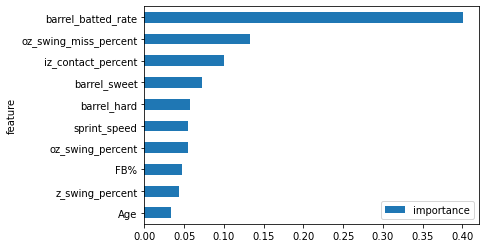

In [175]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

feat_imps = list(zip(X_train.columns,rf.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')

In [453]:
rf.feature_importances_

array([0.40134745, 0.05757121, 0.07281031, 0.04735996, 0.03340585,
       0.04386422, 0.05508541, 0.10053106, 0.13289354, 0.05513099])

In [216]:
feat_imps

,feature,importance
0,Age,0.033406
1,z_swing_percent,0.043864
2,FB%,0.047360
3,oz_swing_percent,0.055085
4,sprint_speed,0.055131
5,barrel_hard,0.057571
6,barrel_sweet,0.072810
7,iz_contact_percent,0.100531
8,oz_swing_miss_percent,0.132894
9,barrel_batted_rate,0.401347


## Regularization - Lasso

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [26]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [27]:
X_tr = std.transform(X_train.values)

In [28]:
pd.DataFrame(X_tr).describe()

,0,1,2,3,4,5,6,7,8
count,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03
mean,2.537653e-17,7.382262e-17,6.690175e-16,-1.626405e-16,-8.766436e-17,-1.375523e-16,-2.756814e-16,7.151566e-17,1.990904e-15
std,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00
min,-1.666150e+00,-3.641683e+00,-4.597180e+00,-2.928793e+00,-2.404830e+00,-2.942804e+00,-3.168163e+00,-2.854622e+00,-3.416283e+00
25%,-7.565178e-01,-5.851504e-01,-6.708039e-01,-7.112819e-01,-8.765886e-01,-6.962744e-01,-7.257021e-01,-6.991289e-01,-6.264243e-01
50%,-1.248284e-01,6.166760e-02,-1.640788e-02,-2.308873e-02,-1.124680e-01,-2.838718e-02,-3.139818e-02,-1.517432e-02,1.042531e-01
75%,6.331989e-01,6.704375e-01,7.013168e-01,6.651044e-01,6.516527e-01,6.395000e-01,6.975554e-01,6.480544e-01,7.020800e-01
max,5.004489e+00,3.426812e+00,3.297792e+00,4.010488e+00,3.708135e+00,2.886030e+00,3.139368e+00,3.819117e+00,2.628411e+00


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

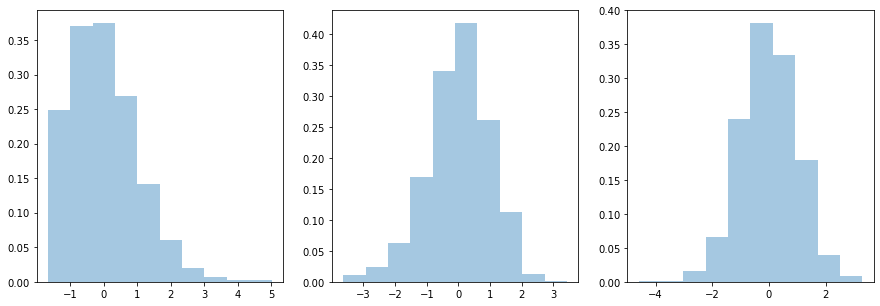

In [242]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(X_tr[:, 0], label='feature 1', ax=axes[0], kde=False, bins=10, norm_hist=True)
sns.distplot(X_tr[:, 1], label='feature 2', ax=axes[1], kde=False, bins=10, norm_hist=True)
sns.distplot(X_tr[:, 2], label='feature 3', ax=axes[2], kde=False, bins=10, norm_hist=True)

In [295]:
lasso_model = Lasso(alpha = 1)
lasso_model.fit(X_tr,y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('barrel_batted_rate', 19.612618143063443),
 ('barrel_hard', 3.5838120527055874),
 ('barrel_sweet', 4.004739778735958),
 ('FB%', -0.0),
 ('Age_m', -0.4989354703379542),
 ('swing_percent', -4.059483159099238),
 ('z_s_contact_percent', 4.457005918471097),
 ('oz_swing_miss_percent', -8.165666994393268),
 ('sprint_speed', 3.276944290501193)]

In [413]:
lm.fit(X_train, y_train)
r2_score(y_train,lm.predict(X_train))

0.6032943435610449

In [298]:
lasso_model = Lasso(alpha = 0.01)
lasso_model.fit(X_tr,y_train)
lasso_model.score(X_tr,y_train)

0.6032910593033003

In [255]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [301]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.values, y_train)
 
    err_vec_val[i] = mae(y_train, pipe.predict(X_train.values))

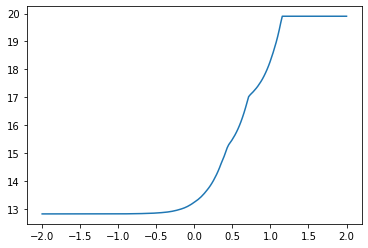

In [302]:
plt.plot(np.log10(alphalist), err_vec_val)

In [303]:
np.min(err_vec_val)

12.81350235072464

In [304]:
alphalist[np.argmin(err_vec_val)]

0.05291978735958442

In [360]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [361]:
lasso_model.alpha_

0.01

In [362]:
list(zip(X_train.columns, lasso_model.coef_))

[('barrel_batted_rate', 24.736620662590575),
 ('barrel_hard', 3.8845360100732287),
 ('barrel_sweet', 6.571634291041847),
 ('FB%', -2.704506554540898),
 ('Age_m', -1.5337474899092733),
 ('swing_percent', -7.710295035951992),
 ('z_s_contact_percent', 7.9816738931636015),
 ('oz_swing_miss_percent', -9.308678504631489),
 ('sprint_speed', 4.615378685564493)]

In [363]:
test_set_pred = lasso_model.predict(X_tr)
mae(y_train, test_set_pred)

12.813832235283785

In [364]:
r2_score(y_train, test_set_pred)

0.6032910593033003

In [365]:

from sklearn.linear_model import lars_path

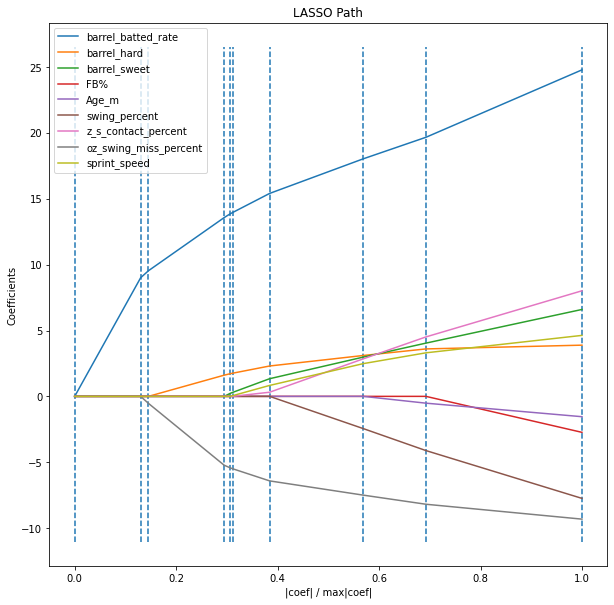

In [366]:
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

## Regularization - Ridge

In [367]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.values, y_train)
 
    err_vec_val[i] = mae(y_train, pipe.predict(X_train.values))

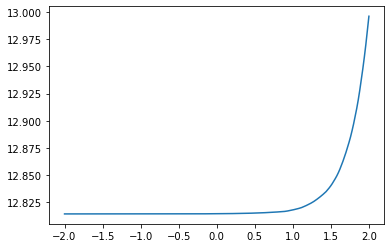

In [368]:
plt.plot(np.log10(alphalist), err_vec_val)

In [369]:
np.min(err_vec_val)

12.814115139537371

In [370]:
alphalist[np.argmin(err_vec_val)]

0.01

In [371]:
alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [372]:
ridge_model.alpha_

0.01

In [373]:
list(zip(X_train.columns, ridge_model.coef_))

[('barrel_batted_rate', 24.787933002844586),
 ('barrel_hard', 3.888053491498088),
 ('barrel_sweet', 6.5977238671588365),
 ('FB%', -2.7316774542154145),
 ('Age_m', -1.5437801198551824),
 ('swing_percent', -7.745168436999741),
 ('z_s_contact_percent', 8.015518966152458),
 ('oz_swing_miss_percent', -9.320579452078773),
 ('sprint_speed', 4.628879086828915)]

In [374]:
test_set_pred = ridge_model.predict(X_tr)
mae(y_train, test_set_pred)

12.814115139537371

In [375]:
r2_score(y_train, test_set_pred)

0.6032943433594189

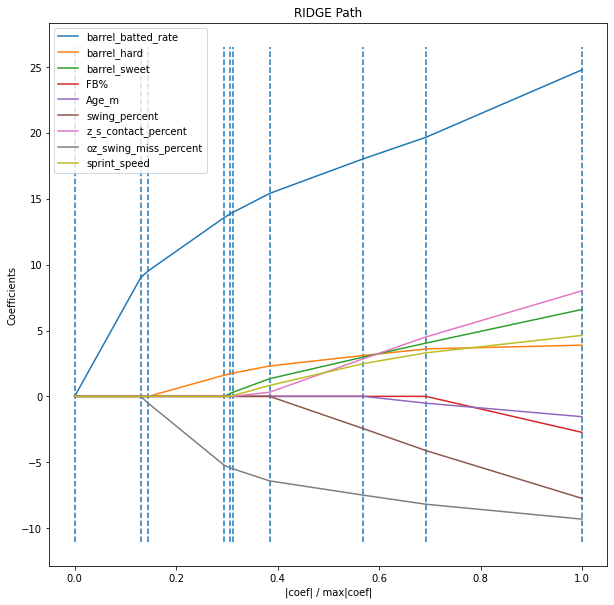

In [376]:
alphas, _, coefs = lars_path(X_tr, y_train.values, method='ridge')
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('RIDGE Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

## VIF

In [351]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [352]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [353]:
vif(X_train)

barrel_batted_rate        10.604323
barrel_hard               38.410313
barrel_sweet              48.673483
FB%                       31.060822
Age_m                      9.963608
swing_percent            219.489959
z_s_contact_percent      292.689153
oz_swing_miss_percent     31.249908
sprint_speed             152.343752
dtype: float64

## Diagnostic_Plots

In [439]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

In [442]:
X_train

,barrel_batted_rate,barrel_hard,barrel_sweet,FB%,Age_m,z_contact,o_s_miss,o_s_contact,sprint_speed
426,9.0,35.7,30.8,25.7,10,56.790123,11.156187,14.807302,28.7
141,8.1,30.3,20.1,21.8,12,57.575758,9.423077,21.153846,28.6
1022,6.2,29.2,30.9,19.1,12,52.095808,11.353033,22.083981,24.8
694,15.3,37.9,21.1,23.7,19,49.722222,12.532637,15.143603,25.4
1799,8.9,34.2,17.7,18.2,7,54.229607,12.031250,10.000000,30.0
...,...,...,...,...,...,...,...,...,...
1130,8.8,33.7,29.6,27.8,12,57.492030,10.845588,15.533088,25.5
1294,3.8,40.1,25.6,20.9,16,43.491736,6.985294,16.299020,26.0
860,1.5,34.2,22.0,18.9,6,46.559633,13.874346,13.874346,29.8
1459,3.9,28.0,36.1,29.0,13,59.317212,11.961057,18.358832,25.7


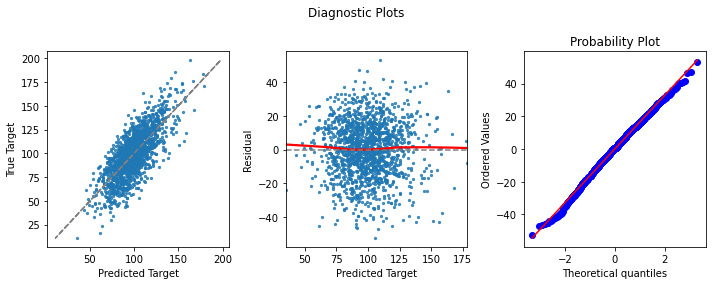

In [444]:
diagnostic_plots(fit.fittedvalues, y_train, fit.resid)

## EDA

In [232]:
df_eda = pd.merge(X_train, y_train, left_index=True, right_index=True)

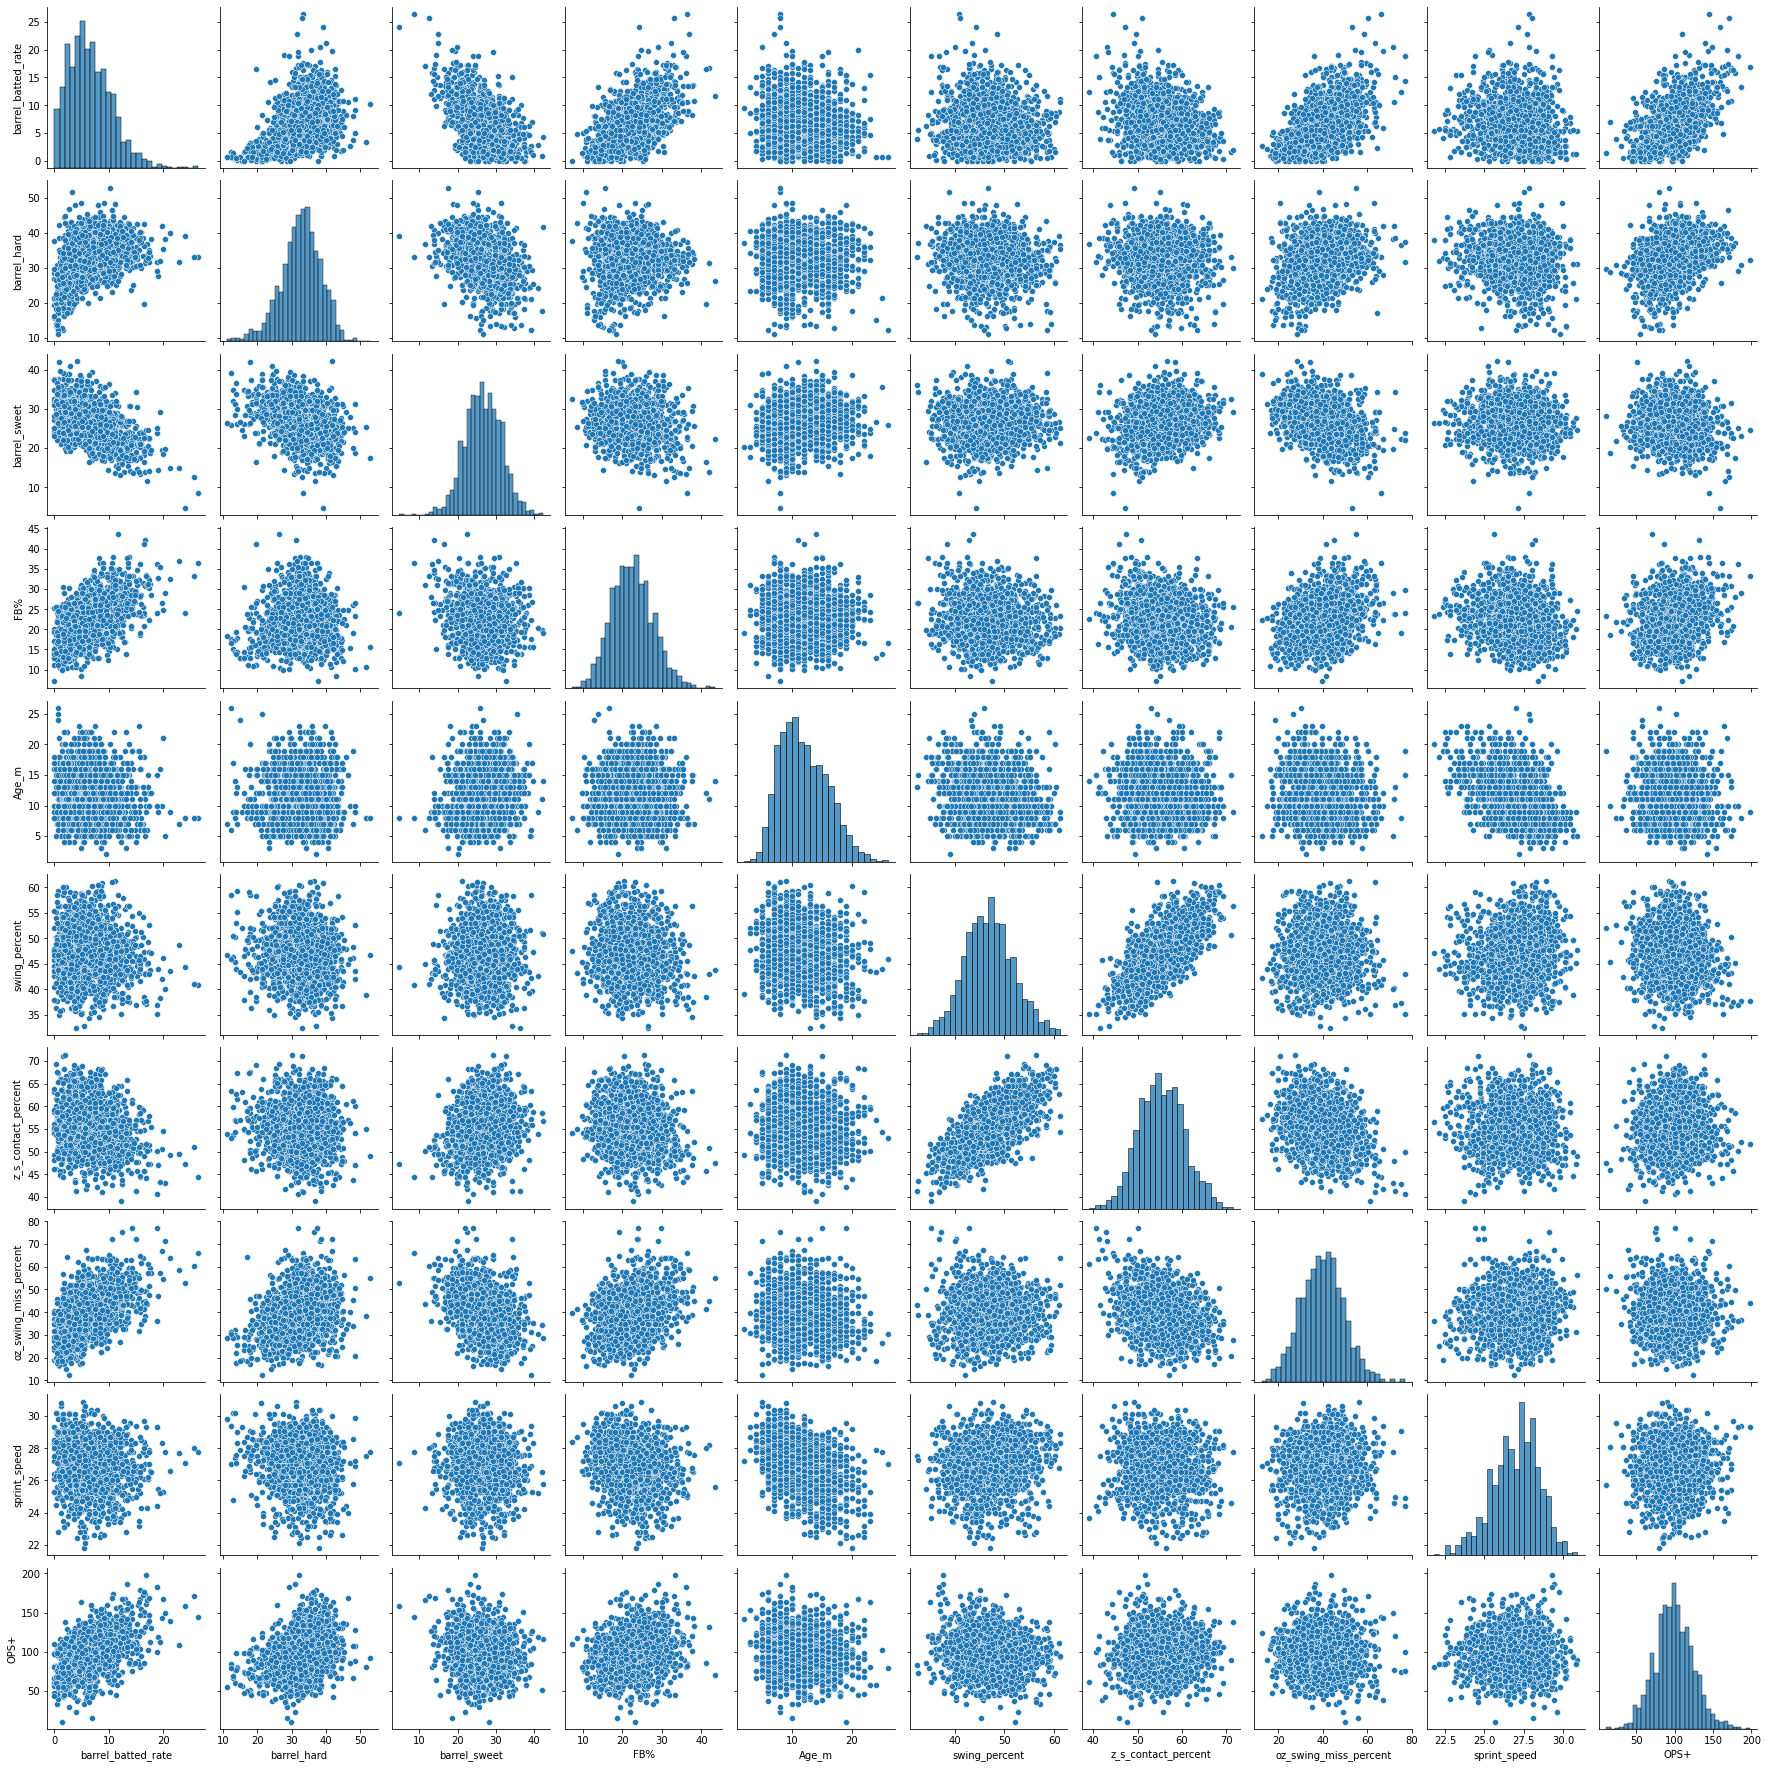

In [233]:
sns.pairplot(df_eda)
plt.savefig("pairplot.png", facecolor ="w", bbox_inches="tight");

In [234]:
df_eda.corr()

,barrel_batted_rate,barrel_hard,barrel_sweet,FB%,Age_m,swing_percent,z_s_contact_percent,oz_swing_miss_percent,sprint_speed,OPS+
barrel_batted_rate,1.000000,0.401324,-0.555238,0.548508,-0.056457,-0.067769,-0.243947,0.540043,-0.130440,0.560745
barrel_hard,0.401324,1.000000,-0.362234,0.000432,0.002721,-0.080614,-0.083861,0.230773,-0.125671,0.341838
barrel_sweet,-0.555238,-0.362234,1.000000,-0.133683,0.106175,0.003510,0.214148,-0.352256,-0.014361,-0.136829
FB%,0.548508,0.000432,-0.133683,1.000000,0.033621,-0.104773,-0.140431,0.302728,-0.172458,0.236769
Age_m,-0.056457,0.002721,0.106175,0.033621,1.000000,-0.178788,-0.008350,-0.134411,-0.467125,-0.075615
swing_percent,-0.067769,-0.080614,0.003510,-0.104773,-0.178788,1.000000,0.693566,0.015514,0.095780,-0.130063
z_s_contact_percent,-0.243947,-0.083861,0.214148,-0.140431,-0.008350,0.693566,1.000000,-0.328420,-0.030574,0.039461
oz_swing_miss_percent,0.540043,0.230773,-0.352256,0.302728,-0.134411,0.015514,-0.328420,1.000000,0.085535,-0.013304
sprint_speed,-0.130440,-0.125671,-0.014361,-0.172458,-0.467125,0.095780,-0.030574,0.085535,1.000000,0.008696
OPS+,0.560745,0.341838,-0.136829,0.236769,-0.075615,-0.130063,0.039461,-0.013304,0.008696,1.000000


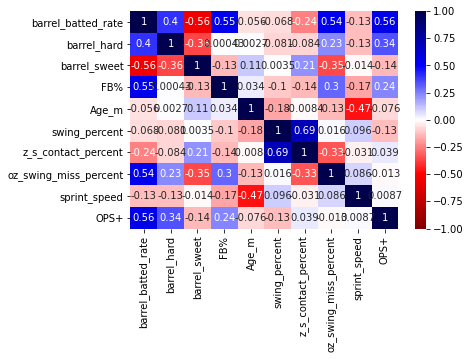

In [235]:
upper = np.triu(df_eda.corr())
sns.heatmap(df_eda.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1);

In [180]:
lr_model_ridge = Ridge(alpha = 1000000000000)
lr_model_ridge.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('Age', -1.1652622567480791e-08),
 ('Debut', 3.701119890082847e-10),
 ('OPS+_3y_0', 3.4422266900786596e-07),
 ('PA_3y_0', 1.6364000044630364e-06),
 ('PA_cum_0', 6.501905169811993e-06),
 ('p/pa', 1.5058141698937449e-09),
 ('HardH%', 1.6543871844414952e-07),
 ('launch_angle_avg', 2.7295281824841452e-08),
 ('LD%', 3.72691776692361e-08),
 ('GB/FB', -7.187612588640868e-09),
 ('Pull%', 2.429764210324379e-08),
 ('Oppo%', -1.797188523269955e-08),
 ('z_swing_percent', 7.83367477911716e-09),
 ('iz_contact_percent', 2.01947022764044e-09),
 ('oz_swing_percent', -3.0249997944782546e-08),
 ('sprint_speed', 5.237250455147653e-10)]

In [181]:
lr_model_lasso = Lasso(alpha = 100000)
lr_model_lasso.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_lasso.coef_))

[('Age', -0.0),
 ('Debut', 0.0),
 ('OPS+_3y_0', 0.0),
 ('PA_3y_0', 0.0),
 ('PA_cum_0', 0.0),
 ('p/pa', 0.0),
 ('HardH%', 0.0),
 ('launch_angle_avg', 0.0),
 ('LD%', 0.0),
 ('GB/FB', -0.0),
 ('Pull%', 0.0),
 ('Oppo%', -0.0),
 ('z_swing_percent', 0.0),
 ('iz_contact_percent', 0.0),
 ('oz_swing_percent', -0.0),
 ('sprint_speed', 0.0)]

## transform

In [47]:
X_train = df_train[['barrel_t','barrel_hard','barrel_sweet','FB%','swing_percent','Age_t',
                    'z_swing_percent','iz_contact_percent','oz_swing_miss_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     216.5
Date:                Wed, 29 Sep 2021   Prob (F-statistic):          2.12e-284
Time:                        13:22:52   Log-Likelihood:                -6483.4
No. Observations:                1540   AIC:                         1.299e+04
Df Residuals:                    1529   BIC:                         1.305e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -103.0490     17.352     -5.939      0.000    -137.086     -69.012
barrel_t                 13.6606      0.408     33.507      0.000      12.861      14.460
barrel_hard               0.3316      0.087      3.824      0.000       0.162       0.502
barrel_sweet              1.1738      0.110     10.646      0.000       0.958       1.390
FB%                      -0.6212      0.106     -5.868      0.000      -0.829      -0.414
swing_percent            -1.7316      0.174     -9.936      0.000      -2.073      -1.390
Age_t                    -1.7596      0.530     -3.317      0.001      -2.800      -0.719
z_swing_percent           1.3287      0.149      8.895      0.000       1.036       1.622
iz_contact_percent        1.0347      0.118      8.772      0.000       0.803       1.266
oz_swing_miss_percent    -0.9703      0.065    -14.939      0.000      -1.098      -0.843
sprint_speed              3.1041      0.326      9.509      0.000       2.464       3.744
==============================================================================
Omnibus:                        3.655   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                3.669
Skew:                          -0.119   Prob(JB):                        0.160
Kurtosis:                       2.978   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
df_train.barrel_batted_rate.describe()

count    1540.000000
mean        6.594026
std         3.958927
min         0.000000
25%         3.600000
50%         6.100000
75%         9.100000
max        26.400000
Name: barrel_batted_rate, dtype: float64

(array([256., 381., 385., 277., 146.,  62.,  21.,   7.,   2.,   3.]),
 array([ 0.  ,  2.64,  5.28,  7.92, 10.56, 13.2 , 15.84, 18.48, 21.12,
        23.76, 26.4 ]),
 <BarContainer object of 10 artists>)

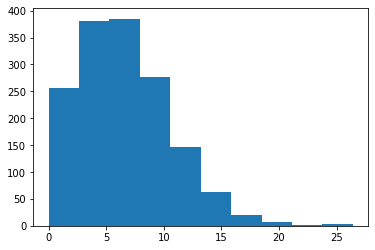

In [34]:
plt.hist(df_train.barrel_batted_rate)

In [42]:
df_train[['barrel_batted_rate']].sort_values(by = ['barrel_batted_rate'])

,barrel_batted_rate
1673,0.0
431,0.0
1309,0.0
842,0.0
1698,0.0
...,...
797,21.2
1207,22.9
724,24.1
1056,25.7


Lambda: 0.5742648249949016


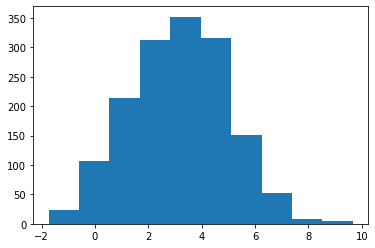

In [44]:
lamb=stats.boxcox_normmax(df_train.barrel_batted_rate.replace(0.0,0.0000000001), brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
barrel_t=(np.power(df_train.barrel_batted_rate,lamb)-1)/lamb

plt.hist(barrel_t);

In [46]:
df_train['barrel_t'] = barrel_t

/var/folders/5j/jyxtrn7n0cl1j0jb8nzdk5dr0000gn/T/ipykernel_13217/418944861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['barrel_t'] = barrel_t


In [ ]:
plt.hist(df_train.Age_m);

Lambda: 0.39741335407750306


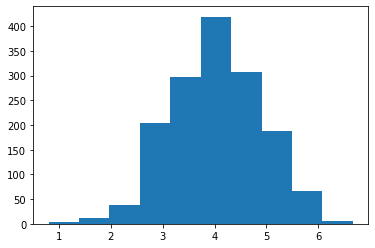

In [9]:
lamb=stats.boxcox_normmax(df_train.Age_m, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
Age_t=(np.power(df_train.Age_m,lamb)-1)/lamb

plt.hist(Age_t);

In [16]:
df_train.Age_t = Age_t


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
lamb=stats.boxcox_normmax(df_train.Age_m, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_t=(np.power(df_train.Age_m,lamb)-1)/lamb

plt.hist(y_t);

(array([  1.,   3.,  11.,  38., 203., 297., 419., 308., 234.,  26.]),
 array([0.69314718, 0.94964212, 1.20613705, 1.46263199, 1.71912692,
        1.97562186, 2.2321168 , 2.48861173, 2.74510667, 3.0016016 ,
        3.25809654]),
 <BarContainer object of 10 artists>)

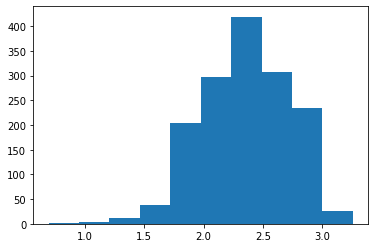

In [10]:
np.log(df_train.Age_m)
plt.hist(np.log(df_train.Age_m))

In [30]:
Age_t

426     3.766784
141     4.238934
1022    4.238934
694     5.592430
1799    2.936418
          ...   
1130    4.238934
1294    5.057128
860     2.612404
1459    4.457272
1126    5.241810
Name: Age_m, Length: 1540, dtype: float64